In [1]:
import pandas as pd, numpy as np, statsmodels.formula.api as smf


In [2]:
df = pd.read_csv('/Users/danielseymour/Developer/EC334-Summative/processed_data/three_digit_NAICS_bds_tfp.csv')
df.head()

,year,NAICS,firms,estabs,emp,denom,estabs_entry,estabs_entry_rate,estabs_exit,estabs_exit_rate,...,reallocation_rate,firmdeath_firms,firmdeath_estabs,firmdeath_emp,Industry,Basis,weight,tfp_pct_change,tfp_index_2017,firms_percent_destroyed
0,1987,211,7297,8942,130532,142230,909,9.665,1836,19.520,...,27.415,1204,1216,5416,Oil and gas extraction,All workers,0.023260,NaN,60.776,16.499931
1,1987,212,6245,8515,285319,296796,1120,13.007,1312,15.236,...,32.163,767,775,9355,"Mining, except oil and gas",All workers,0.012166,NaN,86.967,12.281825
2,1987,213,8315,9765,162956,193482,1262,11.900,2942,27.742,...,31.693,2061,2073,17203,Support activities for mining,All workers,0.003770,NaN,58.849,24.786530
3,1987,321,14489,16107,517089,510664,1884,11.717,1828,11.369,...,27.833,1320,1328,18984,Wood products,All workers,0.016190,NaN,104.620,9.110360
4,1987,322,3683,5633,572571,572627,330,5.847,351,6.220,...,14.984,227,228,5271,Paper products,All workers,0.028750,NaN,96.878,6.163454


In [3]:

# -------------------------------------------------
# 0)  Align TFP to the BDS 'year'
# -------------------------------------------------
df = df.sort_values(['Industry', 'year']).copy()
df['tfp_index_bds'] = df.groupby('Industry')['tfp_index_2017'].shift(-1)
df['logTFP']        = np.log(df['tfp_index_bds'])

# -------------------------------------------------
# 1)  Shock: log change in firm births (age-0 establishments)
# -------------------------------------------------
df['logEntry0']  = np.log(df['estabs_entry'])
df['dlogEntry0'] = df.groupby('Industry')['logEntry0'].diff()

# -------------------------------------------------
# 2)  Build leads & lags of TFP
# -------------------------------------------------
MAX_H = 12          # forecast horizon
for h in range(1, MAX_H + 1):
    df[f'F{h}_logTFP'] = df.groupby('Industry')['logTFP'].shift(-h)

df['L0_logTFP'] = df['logTFP']
df['L1_logTFP'] = df.groupby('Industry')['logTFP'].shift(1)

# -------------------------------------------------
# 3)  Empty containers for IRF results
# -------------------------------------------------
irf, lo90, hi90, lo68, hi68 = [], [], [], [], []

# -------------------------------------------------
# 4)  Loop over horizons and run the regression
#     F_h(logTFP) = alpha + beta*dlogEntry0 + phi*L0 + rho*L1 + FE
# -------------------------------------------------
for h in range(1, MAX_H + 1):
    dep   = f'F{h}_logTFP'
    keep  = [dep, 'dlogEntry0', 'L0_logTFP', 'L1_logTFP', 'Industry', 'year']
    dm    = df.dropna(subset=keep)

    formula = (f'{dep} ~ dlogEntry0 + L0_logTFP + L1_logTFP '
               '+ C(year) + C(Industry)')

    mod = smf.ols(formula, data=dm).fit(
            cov_type='cluster',
            cov_kwds={'groups': dm['Industry']}
          )

    beta  = mod.params['dlogEntry0']
    se    = mod.bse['dlogEntry0']

    irf.append(beta)
    hi68.append(beta + 1.00*se); lo68.append(beta - 1.00*se)
    hi90.append(beta + 1.65*se); lo90.append(beta - 1.65*se)

# -------------------------------------------------
# 5)  Collect and inspect
# -------------------------------------------------
irf_df = pd.DataFrame({
    'horizon': range(1, MAX_H + 1),
    'IRF': irf,
    'lo68': lo68, 'hi68': hi68,
    'lo90': lo90, 'hi90': hi90
})

print(irf_df.round(4))

    horizon     IRF    lo68    hi68    lo90    hi90
0         1 -0.0197 -0.0295 -0.0100 -0.0358 -0.0037
1         2 -0.0205 -0.0295 -0.0115 -0.0354 -0.0057
2         3  0.0040 -0.0092  0.0172 -0.0178  0.0258
3         4 -0.0352 -0.0447 -0.0258 -0.0508 -0.0197
4         5 -0.0132 -0.0237 -0.0027 -0.0305  0.0041
5         6  0.0000 -0.0211  0.0212 -0.0349  0.0349
6         7 -0.0323 -0.0443 -0.0202 -0.0522 -0.0124
7         8 -0.0272 -0.0404 -0.0140 -0.0491 -0.0054
8         9 -0.0094 -0.0251  0.0063 -0.0352  0.0164
9        10 -0.0364 -0.0528 -0.0199 -0.0636 -0.0092
10       11 -0.0023 -0.0147  0.0100 -0.0227  0.0180
11       12 -0.0060 -0.0232  0.0112 -0.0343  0.0223


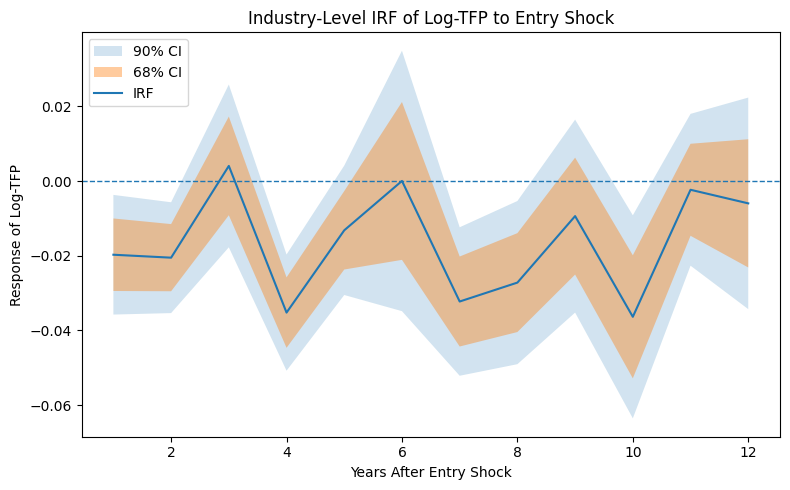

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

# 90% confidence band
plt.fill_between(
    irf_df['horizon'],
    irf_df['lo90'],
    irf_df['hi90'],
    alpha=0.2,
    label='90% CI'
)

# 68% confidence band
plt.fill_between(
    irf_df['horizon'],
    irf_df['lo68'],
    irf_df['hi68'],
    alpha=0.4,
    label='68% CI'
)

# The IRF itself
plt.plot(
    irf_df['horizon'],
    irf_df['IRF'],
    label='IRF'
)

# Zero‐line for reference
plt.axhline(0, linestyle='--', linewidth=1)

# Axes and legend
plt.xlabel('Years After Entry Shock')
plt.ylabel('Response of Log‐TFP')
plt.title('Industry‐Level IRF of Log‐TFP to Entry Shock')
plt.legend()
plt.tight_layout()
plt.show()

/Users/danielseymour/Developer/EC334-Summative/.venv/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/Users/danielseymour/Developer/EC334-Summative/.venv/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/Users/danielseymour/Developer/EC334-Summative/.venv/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/Users/danielseymour/Developer/EC334-Summative/.venv/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/Users/danielseymour/Developer/EC334-Summative/.venv/lib/python3.10/site-packages/statsmodels/regression/linear_

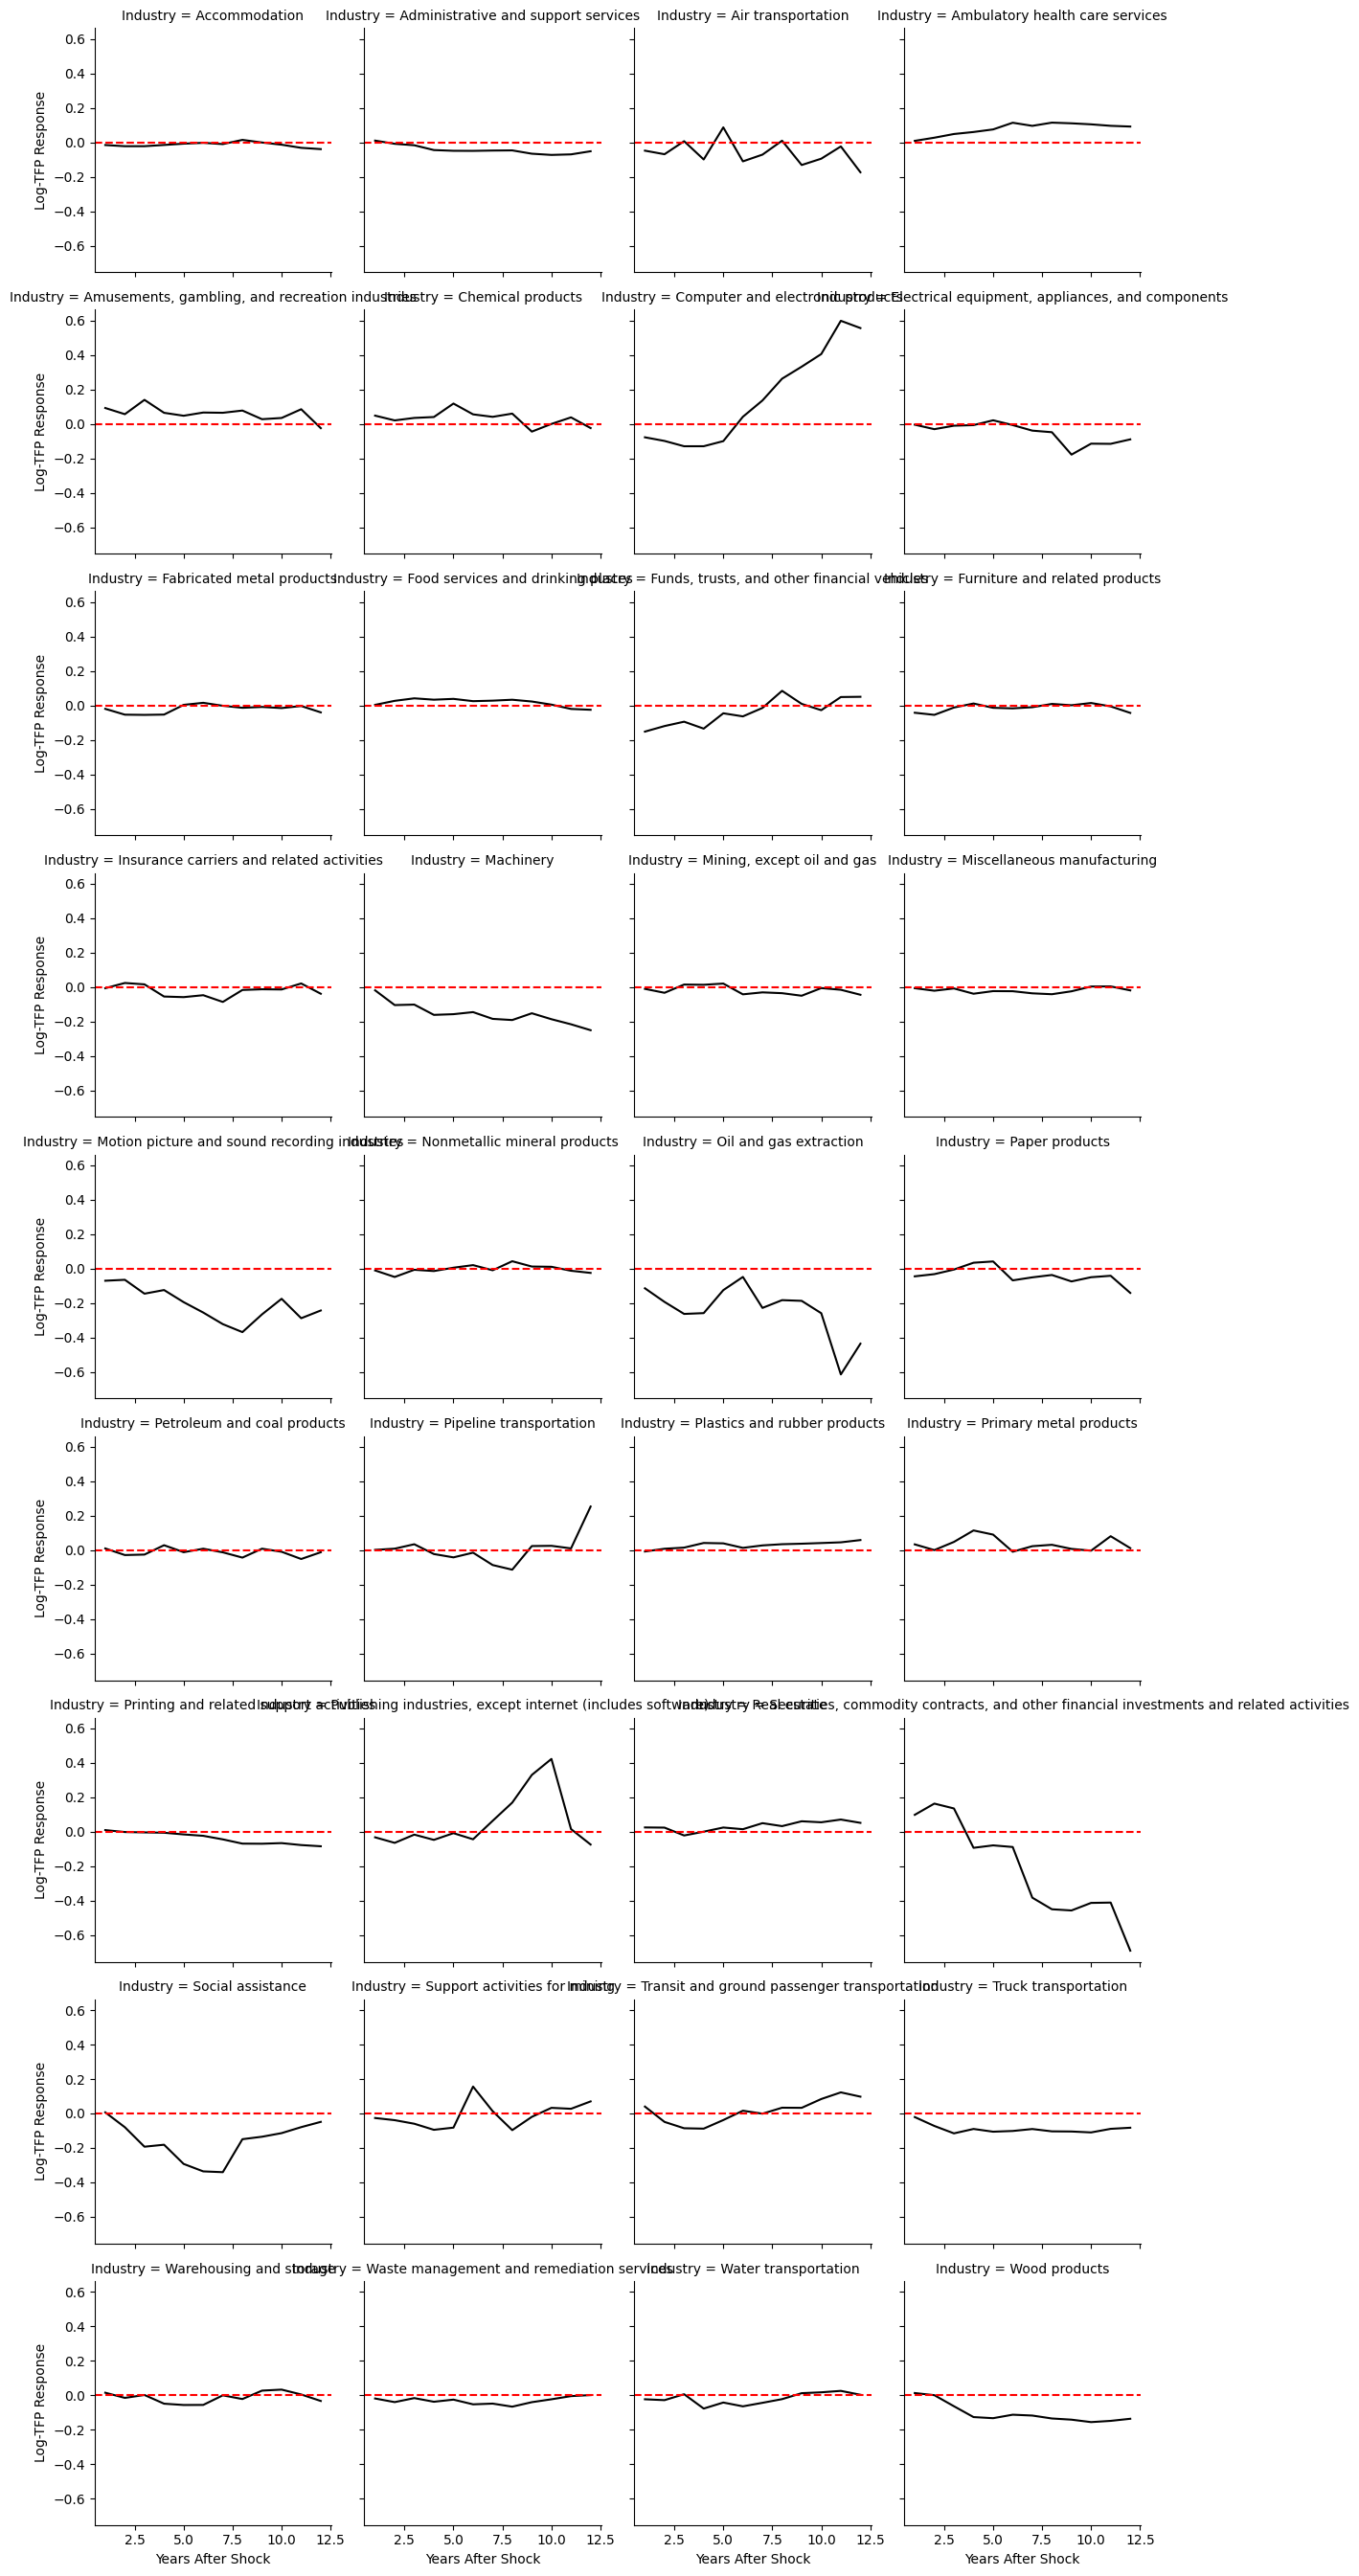

In [8]:
import pandas as pd, numpy as np, statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Define your list of sectors (or just take the top N by size):
sectors = df['Industry'].unique()  # or: ['Manufacturing','Finance',…]

# 2) Container for all sector‐level IRFs
all_irfs = []

for sec in sectors:
    dfi = df[df['Industry'] == sec].copy()
    # make sure logTFP, dlogEntry0, leads & lags are already in dfi…

    irf, lo68, hi68, lo90, hi90 = [], [], [], [], []
    for h in range(1, 13):
        dep = f'F{h}_logTFP'
        keep = [dep, 'dlogEntry0', 'L0_logTFP', 'L1_logTFP']
        dm = dfi.dropna(subset=keep + ['year'])

        mod = smf.ols(
            f"{dep} ~ dlogEntry0 + L0_logTFP + L1_logTFP + C(year)",
            data=dm
        ).fit(
            cov_type='cluster',
            cov_kwds={'groups': dm['year']}
        )

        b, s = mod.params['dlogEntry0'], mod.bse['dlogEntry0']
        irf.append(b)
        lo68.append(b - 1 * s)
        hi68.append(b + 1 * s)
        lo90.append(b - 1.65 * s)
        hi90.append(b + 1.65 * s)

    tmp = pd.DataFrame({
        'Industry': sec,
        'horizon': range(1, 13),
        'IRF': irf,
        'lo68': lo68, 'hi68': hi68,
        'lo90': lo90, 'hi90': hi90
    })
    all_irfs.append(tmp)

irf_sector_df = pd.concat(all_irfs, ignore_index=True)

# 3) Plot them by sector (facet‐grid for legibility)
g = sns.FacetGrid(irf_sector_df,
                  col="Industry", col_wrap=4, sharey=True, height=3)
g.map_dataframe(sns.lineplot, "horizon", "IRF", color="black")
g.map_dataframe(plt.fill_between, "horizon", "lo90", "hi90",
                alpha=0.2, color="gray")
g.map_dataframe(plt.fill_between, "horizon", "lo68", "hi68",
                alpha=0.4, color="gray")
for ax in g.axes.flatten():
    ax.axhline(0, ls="--", c="red")
    ax.set_xlabel("Years After Shock")
    ax.set_ylabel("Log-TFP Response")
plt.tight_layout()
plt.show()